# End-to-End Quantitative Research Pipeline

This notebook demonstrates a complete quantitative research workflow:

1. **Data Loading & Exploration** - Load price data for AAPL, MSFT, TSLA
2. **Feature Engineering** - Create technical indicators and signals
3. **Signal Evaluation** - Assess predictive power and combine signals
4. **Portfolio Construction** - Transform signals into position weights
5. **Backtesting** - Simulate portfolio performance with transaction costs
6. **Performance Analysis** - Evaluate results and visualize performance

Let's build a systematic approach to developing and evaluating quantitative strategies.


In [1]:
# Import required libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add src to path to import qbt
sys.path.insert(0, os.path.join('..', 'src'))

import qbt
from qbt import features, signals, portfolio
from qbt.data import load_prices_long_csv, pivot_close, merge_wide

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("qbt version:", qbt.__version__)
print("Libraries imported successfully!")


qbt version: 0.1.0
Libraries imported successfully!


## 1. Data Loading & Exploration

First, let's load and examine our three stock datasets. We'll convert the data from long format to wide format for easier analysis.


In [2]:
# Load individual CSV files and combine them
data_path = "../data/raw/"

# Load each stock's data
stocks = ['AAPL', 'MSFT', 'TSLA']
all_data = []

for stock in stocks:
    df = pd.read_csv(os.path.join(data_path, f"{stock}.csv"))
    print(f"Loaded {stock}: {len(df)} rows")
    all_data.append(df)

# Combine all data
combined_df = pd.concat(all_data, ignore_index=True)
print(f"\nCombined dataset: {len(combined_df)} rows")
print(f"Date range: {combined_df['date'].min()} to {combined_df['date'].max()}")
print(f"Tickers: {sorted(combined_df['ticker'].unique())}")

# Show sample of the data
print("\nSample data:")
combined_df.head(10)


Loaded AAPL: 174 rows
Loaded MSFT: 174 rows
Loaded TSLA: 174 rows

Combined dataset: 522 rows
Date range: 01/04/2025 to 31/07/2025
Tickers: ['AAPL', 'MSFT', 'TSLA']

Sample data:


,date,ticker,open,high,low,close,volume
0,02/01/2025,AAPL,248.93,249.10,241.82,243.85,55.74M
1,03/01/2025,AAPL,243.36,244.18,241.89,243.36,40.24M
2,06/01/2025,AAPL,244.31,247.33,243.20,245.00,45.05M
3,07/01/2025,AAPL,242.98,245.55,241.35,242.21,40.86M
4,08/01/2025,AAPL,241.92,243.71,240.05,242.70,37.63M
5,10/01/2025,AAPL,240.01,240.16,233.00,236.85,61.71M
6,13/01/2025,AAPL,233.53,234.67,229.72,234.40,49.63M
7,14/01/2025,AAPL,234.75,236.12,232.47,233.28,39.44M
8,15/01/2025,AAPL,234.63,238.96,234.43,237.87,39.83M
9,16/01/2025,AAPL,237.35,238.01,228.03,228.26,71.76M


In [3]:
# Convert to proper date format and create wide format price matrix
combined_df['date'] = pd.to_datetime(combined_df['date'], format='%d/%m/%Y')

# Create wide format DataFrames for different price series
close_wide = combined_df.pivot(index='date', columns='ticker', values='close')
open_wide = combined_df.pivot(index='date', columns='ticker', values='open')
high_wide = combined_df.pivot(index='date', columns='ticker', values='high')
low_wide = combined_df.pivot(index='date', columns='ticker', values='low')

# Convert volume (remove 'M' suffix and convert to millions)
combined_df['volume_numeric'] = combined_df['volume'].str.replace('M', '').astype(float) * 1_000_000
volume_wide = combined_df.pivot(index='date', columns='ticker', values='volume_numeric')

print("Price data shapes:")
print(f"Close prices: {close_wide.shape}")
print(f"Date range: {close_wide.index.min()} to {close_wide.index.max()}")
print(f"Number of trading days: {len(close_wide)}")

# Display the close price matrix
print("\nClose prices (wide format):")
close_wide.head()


Price data shapes:
Close prices: (174, 3)
Date range: 2025-01-02 00:00:00 to 2025-09-12 00:00:00
Number of trading days: 174

Close prices (wide format):


ticker,AAPL,MSFT,TSLA
date,,,
2025-01-02,243.85,418.58,379.28
2025-01-03,243.36,423.35,410.44
2025-01-06,245.00,427.85,411.05
2025-01-07,242.21,422.37,394.36
2025-01-08,242.70,424.56,394.94


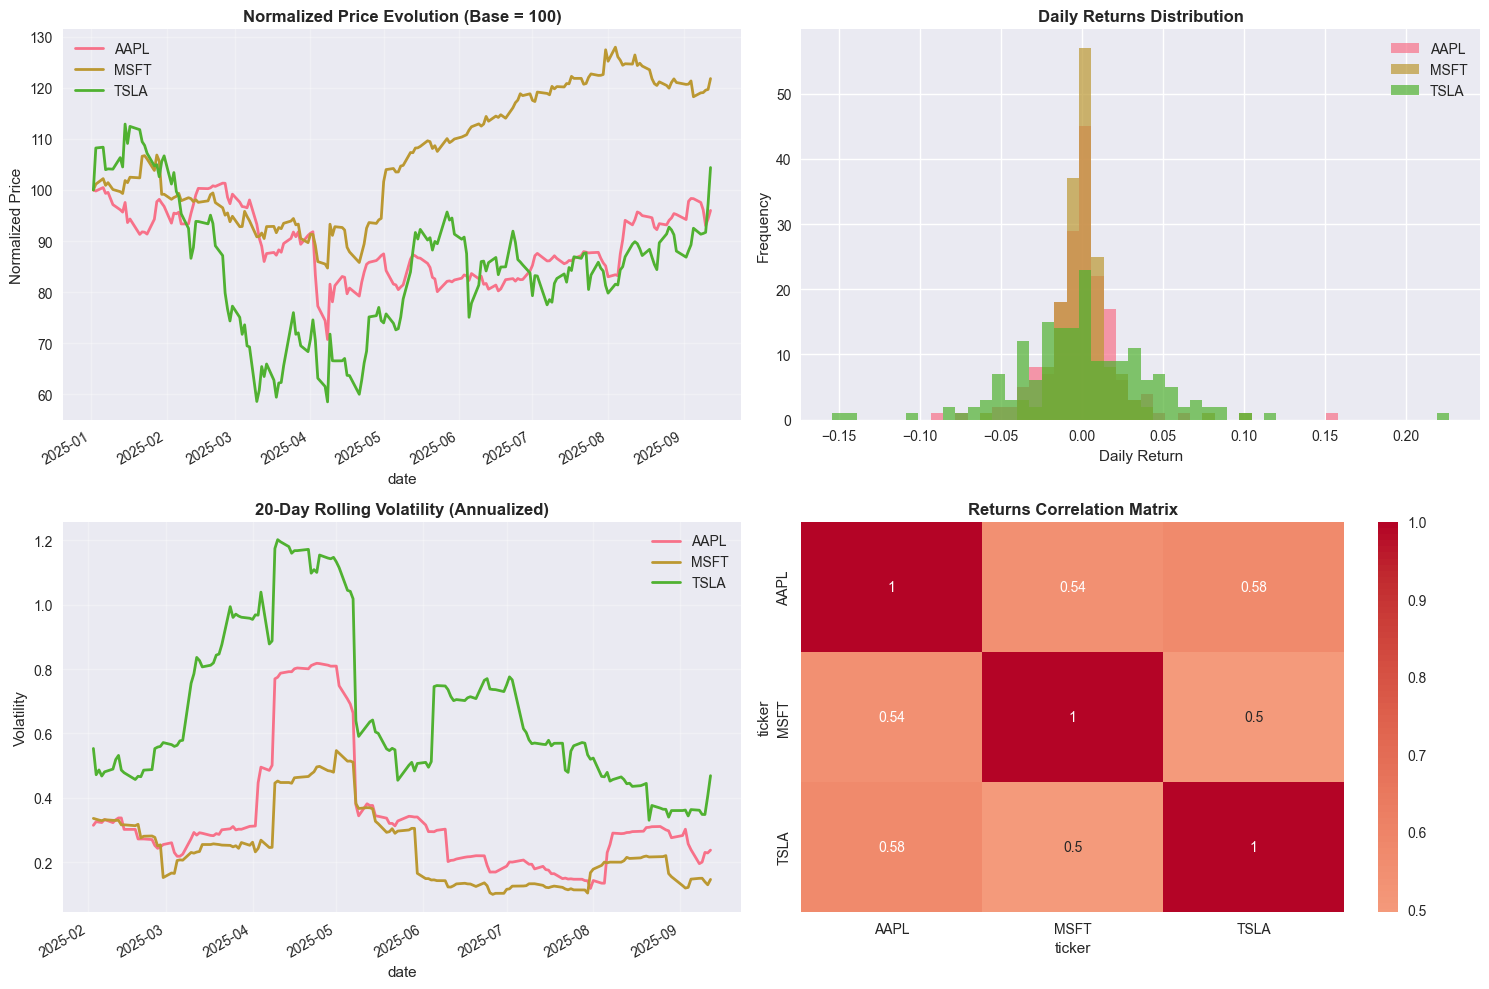

Summary Statistics for Daily Returns:
ticker        AAPL        MSFT        TSLA
count   173.000000  173.000000  173.000000
mean      0.000027    0.001278    0.001194
std       0.023186    0.016719    0.043805
min      -0.092456   -0.061809   -0.154262
25%      -0.009462   -0.005902   -0.022544
50%       0.000286    0.000455   -0.000357
75%       0.009036    0.006465    0.024384
max       0.153288    0.101337    0.226900


In [4]:
# Visualize price evolution and basic statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price evolution (normalized to 100)
ax1 = axes[0, 0]
price_normalized = close_wide / close_wide.iloc[0] * 100
price_normalized.plot(ax=ax1, linewidth=2)
ax1.set_title('Normalized Price Evolution (Base = 100)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Normalized Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Daily returns distribution
ax2 = axes[0, 1]
returns = close_wide.pct_change().dropna()
returns.plot(kind='hist', bins=50, alpha=0.7, ax=ax2)
ax2.set_title('Daily Returns Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Daily Return')
ax2.legend()

# Rolling 20-day volatility
ax3 = axes[1, 0]
vol_20d = returns.rolling(20).std() * np.sqrt(252)  # Annualized
vol_20d.plot(ax=ax3, linewidth=2)
ax3.set_title('20-Day Rolling Volatility (Annualized)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Volatility')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Correlation matrix
ax4 = axes[1, 1]
corr_matrix = returns.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax4)
ax4.set_title('Returns Correlation Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics for Daily Returns:")
print(returns.describe())


## 2. Feature Engineering

Now let's create various technical features that could be predictive of future returns. We'll implement:
- **Momentum features**: Price momentum over different horizons
- **Mean reversion features**: Deviations from moving averages 
- **Volatility features**: Realized volatility measures
- **Volume features**: Trading activity patterns


In [6]:
# Create momentum features
print("Creating momentum features...")

# 1. Price momentum over multiple horizons
mom_5d = features.momentum(close_wide, lookback=5)    # 1-week momentum
mom_10d = features.momentum(close_wide, lookback=10)  # 2-week momentum
mom_20d = features.momentum(close_wide, lookback=20)  # 1-month momentum
mom_60d = features.momentum(close_wide, lookback=60)  # 3-month momentum

print("Momentum features created:")
print(f"  5-day momentum: {mom_5d.shape}")
print(f"  10-day momentum: {mom_10d.shape}")
print(f"  20-day momentum: {mom_20d.shape}")
print(f"  60-day momentum: {mom_60d.shape}")

# Display sample momentum values
print("\nSample 20-day momentum values:")
mom_20d.tail()


Creating momentum features...
Momentum features created:
  5-day momentum: (174, 3)
  10-day momentum: (174, 3)
  20-day momentum: (174, 3)
  60-day momentum: (174, 3)

Sample 20-day momentum values:


ticker,AAPL,MSFT,TSLA
date,,,
2025-09-08,0.037192,-0.045667,0.050811
2025-09-09,0.031561,-0.044771,0.023420
2025-09-10,-0.012454,-0.054550,0.020391
2025-09-11,-0.014143,-0.037593,0.086717
2025-09-12,0.005542,-0.024077,0.179868


In [7]:
# Create mean reversion features
print("Creating mean reversion features...")

# 2. Mean reversion signals (z-scores from moving averages)
sma_20 = features.sma(close_wide, window=20)
sma_50 = features.sma(close_wide, window=50)

# Price relative to moving averages
price_vs_sma20 = (close_wide - sma_20) / sma_20
price_vs_sma50 = (close_wide - sma_50) / sma_50

# Time-series z-scores (mean reversion)
mr_20d = features.mean_reversion_z(close_wide, short=5, long=20)
mr_60d = features.mean_reversion_z(close_wide, short=20, long=60)

print("Mean reversion features created:")
print(f"  Price vs SMA-20: {price_vs_sma20.shape}")
print(f"  Price vs SMA-50: {price_vs_sma50.shape}")
print(f"  20-day z-score: {mr_20d.shape}")
print(f"  60-day z-score: {mr_60d.shape}")

# Display sample mean reversion values
print("\nSample 20-day mean reversion z-scores:")
mr_20d.tail()


Creating mean reversion features...
Mean reversion features created:
  Price vs SMA-20: (174, 3)
  Price vs SMA-50: (174, 3)
  20-day z-score: (174, 3)
  60-day z-score: (174, 3)

Sample 20-day mean reversion z-scores:


ticker,AAPL,MSFT,TSLA
date,,,
2025-09-08,0.829034,-1.110597,0.281563
2025-09-09,0.650629,-1.151457,0.500828
2025-09-10,0.339484,-1.125547,0.786063
2025-09-11,0.002794,-1.001394,0.998600
2025-09-12,-0.343283,-0.783145,1.126428


In [8]:
# Create volatility and volume features
print("Creating volatility and volume features...")

# 3. Volatility features
vol_10d = features.realized_vol(close_wide, window=10)   # 10-day realized vol
vol_20d = features.realized_vol(close_wide, window=20)   # 20-day realized vol
vol_60d = features.realized_vol(close_wide, window=60)   # 60-day realized vol

# Volatility regime (high vs low vol periods)
vol_zscore = features.ts_zscore(vol_20d, window=60)  # Vol z-score vs 60-day history

# 4. Volume-based features
volume_sma = features.sma(volume_wide, window=20)
volume_ratio = volume_wide / volume_sma  # Volume relative to 20-day average

print("Volatility and volume features created:")
print(f"  10-day volatility: {vol_10d.shape}")
print(f"  20-day volatility: {vol_20d.shape}")
print(f"  60-day volatility: {vol_60d.shape}")
print(f"  Volume ratio: {volume_ratio.shape}")

# Display sample volatility values
print("\nSample 20-day realized volatility:")
vol_20d.tail()


Creating volatility and volume features...
Volatility and volume features created:
  10-day volatility: (174, 3)
  20-day volatility: (174, 3)
  60-day volatility: (174, 3)
  Volume ratio: (174, 3)

Sample 20-day realized volatility:


ticker,AAPL,MSFT,TSLA
date,,,
2025-09-08,0.194912,0.149333,0.361104
2025-09-09,0.199939,0.149518,0.348071
2025-09-10,0.229871,0.138392,0.347783
2025-09-11,0.228289,0.129267,0.405291
2025-09-12,0.237054,0.145881,0.468565


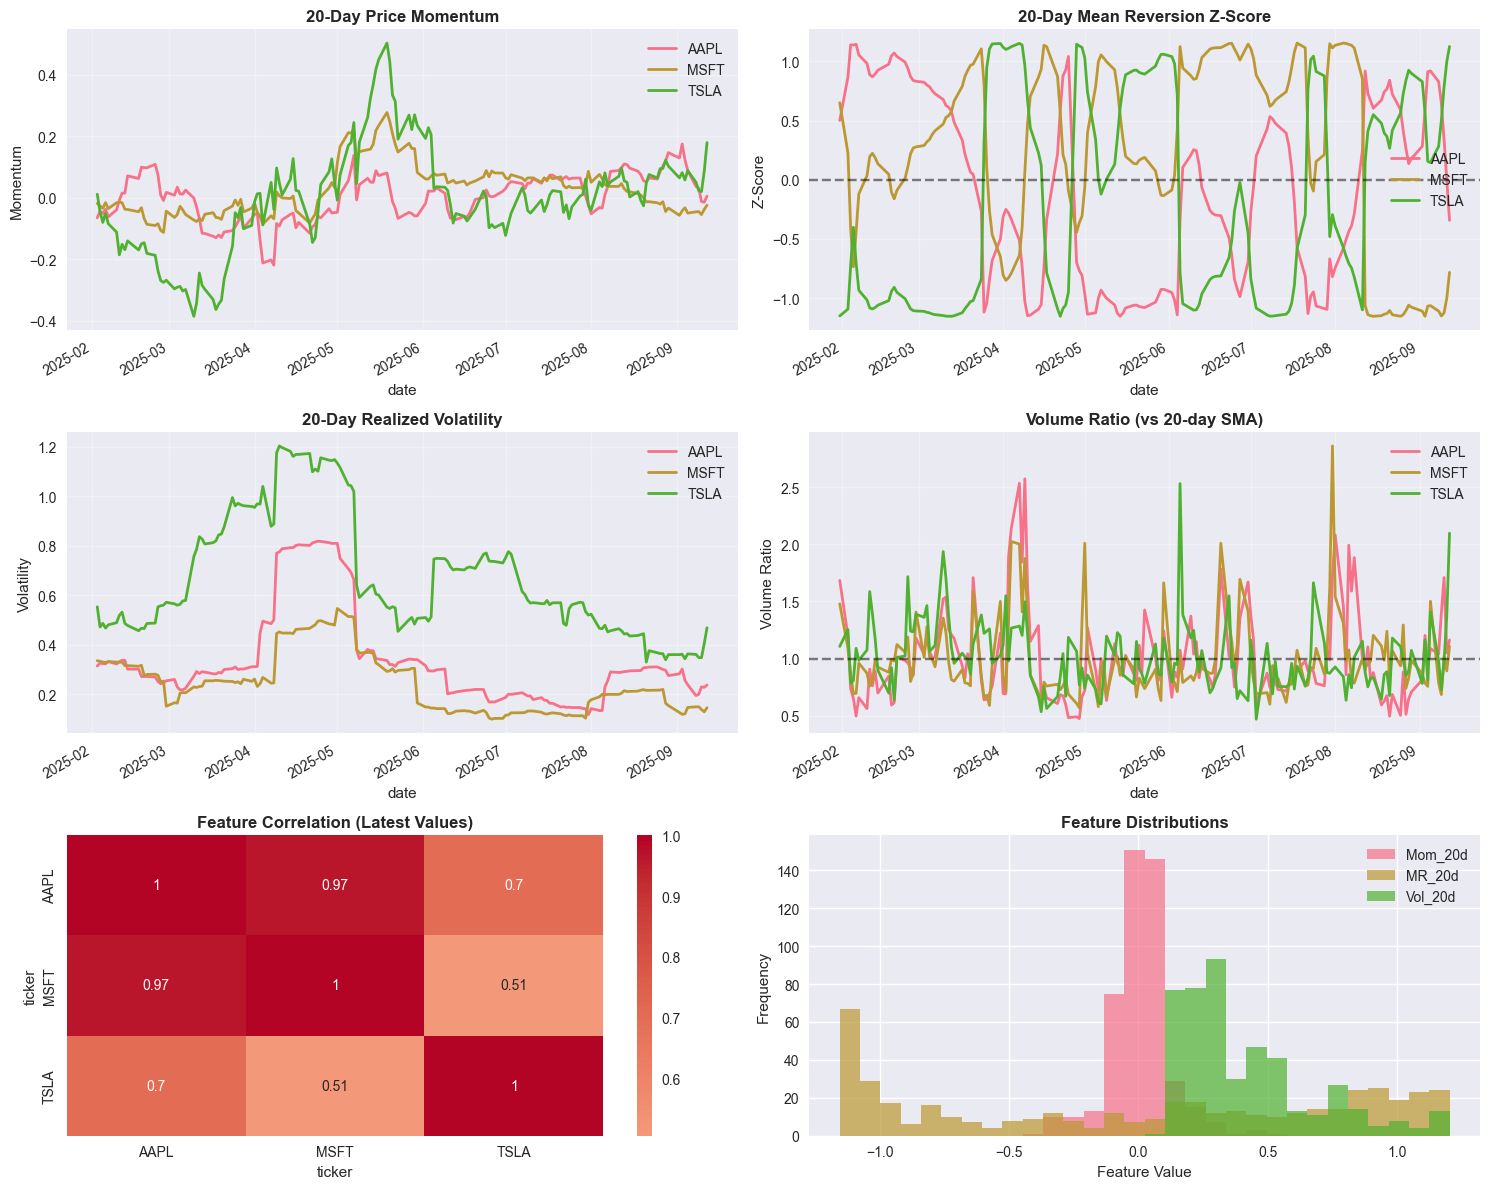

In [9]:
# Visualize feature evolution over time
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plot momentum features
ax1 = axes[0, 0]
mom_20d.plot(ax=ax1, linewidth=2)
ax1.set_title('20-Day Price Momentum', fontsize=12, fontweight='bold')
ax1.set_ylabel('Momentum')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot mean reversion features
ax2 = axes[0, 1]
mr_20d.plot(ax=ax2, linewidth=2)
ax2.set_title('20-Day Mean Reversion Z-Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('Z-Score')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot volatility features
ax3 = axes[1, 0]
vol_20d.plot(ax=ax3, linewidth=2)
ax3.set_title('20-Day Realized Volatility', fontsize=12, fontweight='bold')
ax3.set_ylabel('Volatility')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot volume ratio
ax4 = axes[1, 1]
volume_ratio.plot(ax=ax4, linewidth=2)
ax4.set_title('Volume Ratio (vs 20-day SMA)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Volume Ratio')
ax4.axhline(y=1, color='black', linestyle='--', alpha=0.5)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Feature correlation heatmap (using latest values)
ax5 = axes[2, 0]
feature_data = pd.DataFrame({
    'Mom_5d': mom_5d.iloc[-1],
    'Mom_20d': mom_20d.iloc[-1], 
    'MR_20d': mr_20d.iloc[-1],
    'Vol_20d': vol_20d.iloc[-1],
    'Vol_ratio': volume_ratio.iloc[-1]
}).T
corr_features = feature_data.corr()
sns.heatmap(corr_features, annot=True, cmap='coolwarm', center=0, ax=ax5)
ax5.set_title('Feature Correlation (Latest Values)', fontsize=12, fontweight='bold')

# Feature distributions
ax6 = axes[2, 1]
features_combined = pd.concat([
    mom_20d.stack().rename('Mom_20d'),
    mr_20d.stack().rename('MR_20d'),
    vol_20d.stack().rename('Vol_20d')
], axis=1).dropna()

features_combined.plot(kind='hist', bins=30, alpha=0.7, ax=ax6)
ax6.set_title('Feature Distributions', fontsize=12, fontweight='bold')
ax6.set_xlabel('Feature Value')
ax6.legend()

plt.tight_layout()
plt.show()


## 3. Signal Evaluation & Generation

Now we'll evaluate the predictive power of our features and combine them into actionable trading signals. We'll:
- Calculate forward-looking returns for evaluation
- Assess each feature's Information Coefficient (IC)
- Apply cross-sectional transformations for signal combination
- Create a composite signal


In [10]:
# Calculate forward returns for signal evaluation
print("Calculating forward returns for signal evaluation...")

# Calculate forward returns (what we want to predict)
fwd_returns_1d = close_wide.pct_change(1).shift(-1)  # Next day return
fwd_returns_5d = close_wide.pct_change(5).shift(-5)  # Next 5-day return
fwd_returns_20d = close_wide.pct_change(20).shift(-20)  # Next 20-day return

print("Forward returns calculated:")
print(f"  1-day forward returns: {fwd_returns_1d.shape}")
print(f"  5-day forward returns: {fwd_returns_5d.shape}")
print(f"  20-day forward returns: {fwd_returns_20d.shape}")

# Show sample forward returns
print("\nSample 5-day forward returns:")
fwd_returns_5d.tail()


Calculating forward returns for signal evaluation...
Forward returns calculated:
  1-day forward returns: (174, 3)
  5-day forward returns: (174, 3)
  20-day forward returns: (174, 3)

Sample 5-day forward returns:


ticker,AAPL,MSFT,TSLA
date,,,
2025-09-08,NaN,NaN,NaN
2025-09-09,NaN,NaN,NaN
2025-09-10,NaN,NaN,NaN
2025-09-11,NaN,NaN,NaN
2025-09-12,NaN,NaN,NaN


In [11]:
# Function to calculate Information Coefficient (IC)
def calculate_ic(feature, forward_returns):
    """Calculate rolling Information Coefficient between feature and forward returns."""
    # Stack data to get time-series of cross-sectional correlations
    feature_stacked = feature.stack()
    returns_stacked = forward_returns.stack()
    
    # Align indices
    aligned_data = pd.concat([feature_stacked, returns_stacked], axis=1, keys=['feature', 'returns']).dropna()
    
    if len(aligned_data) == 0:
        return np.nan, np.nan
    
    # Calculate overall correlation
    overall_ic = aligned_data['feature'].corr(aligned_data['returns'])
    
    # Calculate rolling IC by date
    rolling_ic = []
    for date in feature.index:
        if date in forward_returns.index:
            date_feature = feature.loc[date].dropna()
            date_returns = forward_returns.loc[date].dropna()
            
            # Get common tickers
            common_tickers = date_feature.index.intersection(date_returns.index)
            if len(common_tickers) >= 2:  # Need at least 2 points for correlation
                ic = date_feature[common_tickers].corr(date_returns[common_tickers])
                rolling_ic.append(ic)
            else:
                rolling_ic.append(np.nan)
        else:
            rolling_ic.append(np.nan)
    
    rolling_ic_series = pd.Series(rolling_ic, index=feature.index)
    
    return overall_ic, rolling_ic_series

# Evaluate each feature's predictive power
print("Evaluating feature predictive power (Information Coefficient)...")

features_to_evaluate = {
    'Mom_5d': mom_5d,
    'Mom_10d': mom_10d,
    'Mom_20d': mom_20d,
    'MR_20d': mr_20d,
    'MR_60d': mr_60d,
    'Vol_20d': vol_20d,
    'Volume_Ratio': volume_ratio
}

ic_results = {}
ic_rolling = {}

for name, feature in features_to_evaluate.items():
    print(f"Evaluating {name}...")
    
    # Calculate IC vs 5-day forward returns
    overall_ic, rolling_ic = calculate_ic(feature, fwd_returns_5d)
    ic_results[name] = overall_ic
    ic_rolling[name] = rolling_ic

# Display IC results
print("\nInformation Coefficient vs 5-day Forward Returns:")
ic_df = pd.DataFrame.from_dict(ic_results, orient='index', columns=['IC'])
ic_df = ic_df.sort_values('IC', key=abs, ascending=False)
print(ic_df)


Evaluating feature predictive power (Information Coefficient)...
Evaluating Mom_5d...
Evaluating Mom_10d...
Evaluating Mom_20d...
Evaluating MR_20d...
Evaluating MR_60d...
Evaluating Vol_20d...
Evaluating Volume_Ratio...

Information Coefficient vs 5-day Forward Returns:
                    IC
Mom_5d       -0.157261
Vol_20d       0.103402
Mom_10d      -0.067688
MR_20d       -0.039411
Mom_20d       0.038861
MR_60d       -0.037478
Volume_Ratio  0.000673


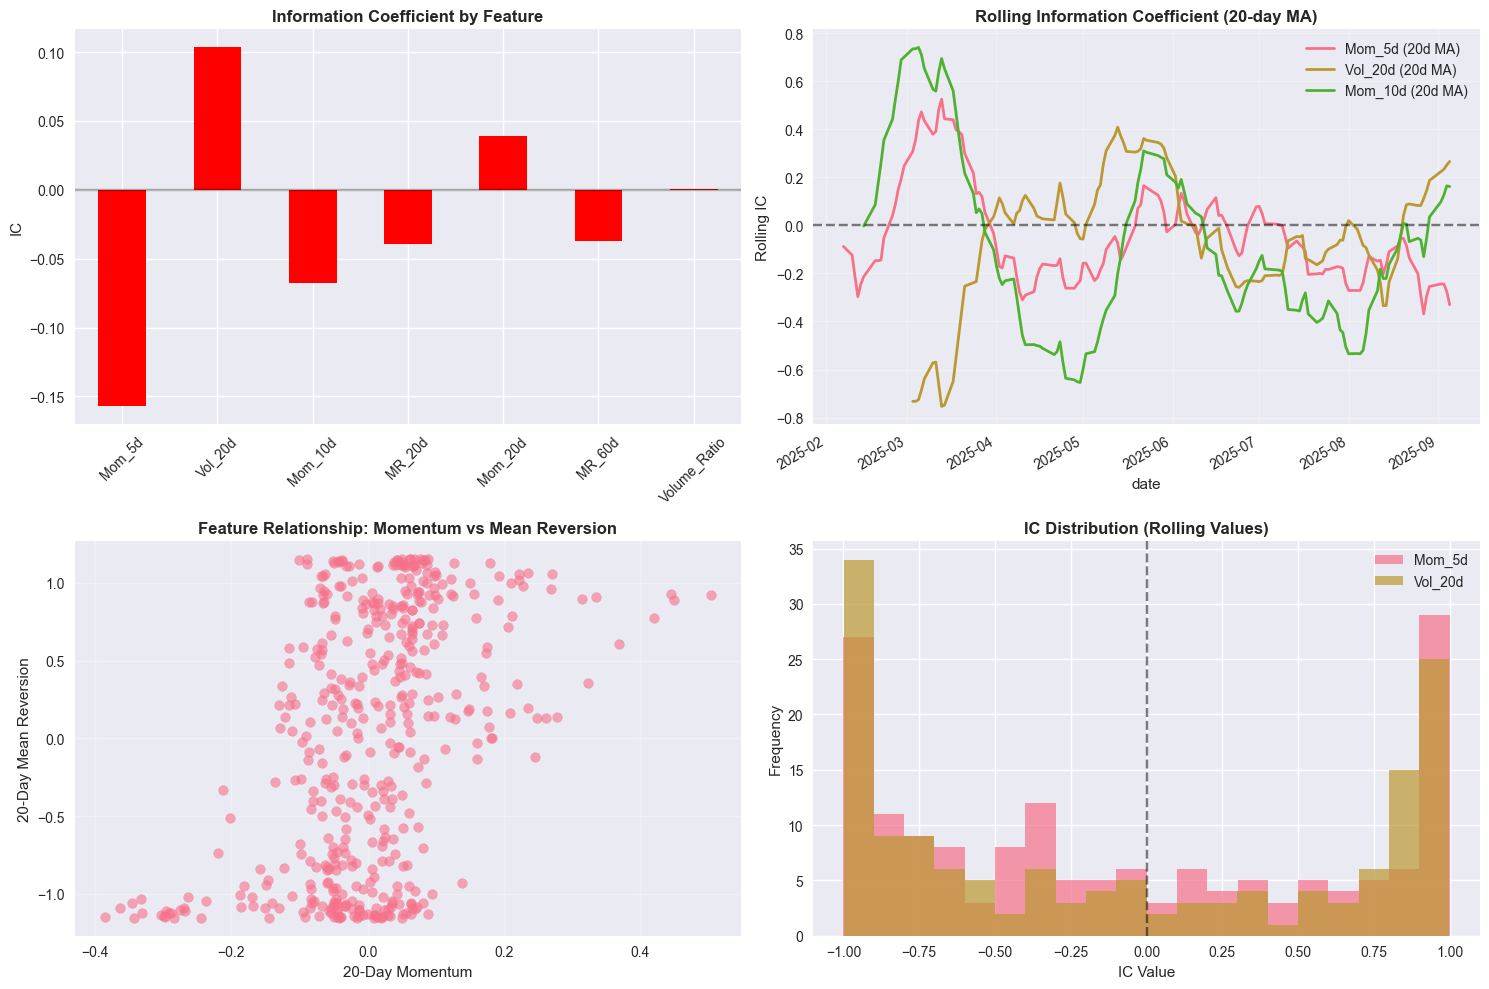

In [12]:
# Visualize Information Coefficient analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# IC bar chart
ax1 = axes[0, 0]
ic_df.plot(kind='bar', ax=ax1, color=['green' if x > 0 else 'red' for x in ic_df['IC']])
ax1.set_title('Information Coefficient by Feature', fontsize=12, fontweight='bold')
ax1.set_ylabel('IC')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
ax1.legend().remove()

# Rolling IC time series for top features
ax2 = axes[0, 1]
top_features = ic_df.head(3).index.tolist()
for feature in top_features:
    if feature in ic_rolling:
        ic_rolling[feature].rolling(20).mean().plot(ax=ax2, label=f'{feature} (20d MA)', linewidth=2)

ax2.set_title('Rolling Information Coefficient (20-day MA)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Rolling IC')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Feature scatter plot (example with momentum vs mean reversion)
ax3 = axes[1, 0]
# Get aligned data for scatter plot
aligned_data = pd.concat([mom_20d.stack(), mr_20d.stack()], axis=1, keys=['Momentum', 'Mean_Reversion']).dropna()
ax3.scatter(aligned_data['Momentum'], aligned_data['Mean_Reversion'], alpha=0.6)
ax3.set_xlabel('20-Day Momentum')
ax3.set_ylabel('20-Day Mean Reversion')
ax3.set_title('Feature Relationship: Momentum vs Mean Reversion', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# IC stability (histogram of rolling ICs)
ax4 = axes[1, 1]
for feature in top_features[:2]:  # Show top 2 features
    if feature in ic_rolling:
        ic_rolling[feature].dropna().plot(kind='hist', alpha=0.7, bins=20, ax=ax4, label=feature)

ax4.set_title('IC Distribution (Rolling Values)', fontsize=12, fontweight='bold')
ax4.set_xlabel('IC Value')
ax4.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax4.legend()

plt.tight_layout()
plt.show()


In [13]:
# Create composite signals using cross-sectional transformations
print("Creating composite trading signals...")

# Select top features based on IC analysis
top_feature_names = ic_df.head(3).index.tolist()
print(f"Using top 3 features by IC: {top_feature_names}")

# Get the corresponding feature DataFrames
selected_features = {}
for name in top_feature_names:
    selected_features[name] = features_to_evaluate[name]

# Apply cross-sectional transformations to each feature
print("\nApplying cross-sectional transformations...")

transformed_signals = {}
for name, feature in selected_features.items():
    print(f"Processing {name}...")
    
    # Step 1: Cross-sectional z-score (standardize across stocks each day)
    cs_zscore = signals.cs_zscore(feature)
    
    # Step 2: Clip extreme values
    clipped = signals.clip_abs(cs_zscore, max_abs=2.5)
    
    # Step 3: Cross-sectional rank (convert to percentile ranks)
    ranked = signals.cs_rank(clipped, pct=True)
    
    # Convert to [-1, +1] range (0.5 becomes 0, 0 becomes -1, 1 becomes +1)
    signal = (ranked - 0.5) * 2
    
    transformed_signals[name] = signal

# Combine signals using IC-weighted average
print("\nCombining signals using IC weights...")

# Normalize IC values to create weights
ic_values = np.array([ic_results[name] for name in top_feature_names])
ic_weights = np.abs(ic_values) / np.sum(np.abs(ic_values))

print("Signal weights:")
for i, name in enumerate(top_feature_names):
    print(f"  {name}: {ic_weights[i]:.3f} (IC: {ic_values[i]:.3f})")

# Create weighted composite signal
composite_signal = pd.DataFrame(0.0, index=close_wide.index, columns=close_wide.columns)

for i, name in enumerate(top_feature_names):
    signal = transformed_signals[name]
    weight = ic_weights[i]
    
    # Add weighted signal (only where both exist)
    composite_signal = composite_signal.add(signal * weight, fill_value=0)

# Final cross-sectional standardization of composite signal
final_signal = signals.cs_zscore(composite_signal)
final_signal = signals.clip_abs(final_signal, max_abs=2.0)

print(f"\nComposite signal shape: {final_signal.shape}")
print("Sample composite signal values:")
final_signal.tail()


Creating composite trading signals...
Using top 3 features by IC: ['Mom_5d', 'Vol_20d', 'Mom_10d']

Applying cross-sectional transformations...
Processing Mom_5d...
Processing Vol_20d...
Processing Mom_10d...

Combining signals using IC weights...
Signal weights:
  Mom_5d: 0.479 (IC: -0.157)
  Vol_20d: 0.315 (IC: 0.103)
  Mom_10d: 0.206 (IC: -0.068)

Composite signal shape: (174, 3)
Sample composite signal values:


ticker,AAPL,MSFT,TSLA
date,,,
2025-09-08,0.225412,-1.093467,0.868055
2025-09-09,0.225412,-1.093467,0.868055
2025-09-10,-0.884340,-0.200836,1.085176
2025-09-11,-0.552871,-0.601488,1.154359
2025-09-12,-0.552871,-0.601488,1.154359


## 4. Portfolio Construction & Performance Analysis

Now we'll transform our composite signal into actual portfolio positions and analyze the resulting performance. We'll:
- **Convert signals to position weights** using signal-based weighting
- **Calculate portfolio returns** from positions and price data
- **Analyze transaction costs** and turnover
- **Visualize performance** with comprehensive plots
- **Compute key metrics** (Sharpe ratio, drawdowns, etc.)


In [14]:
# Convert signals to portfolio positions using signal-based weighting
print("Converting signals to portfolio positions...")

# Use signal-weighted positions with reasonable constraints
positions = portfolio.signal_weighted_positions(
    signals=final_signal,
    leverage=1.0,           # Target 100% gross leverage
    normalize_method="sum", # Normalize by sum of absolute signals
    max_weight=0.50,        # Maximum 50% position in any single asset
    min_signal=0.1          # Minimum signal threshold (filter noise)
)

print(f"Portfolio positions shape: {positions.shape}")
print(f"Position date range: {positions.index.min()} to {positions.index.max()}")

# Display position statistics
gross_leverage = portfolio.compute_leverage(positions)
num_positions = (positions != 0).sum(axis=1)

print("\nPosition Statistics:")
print(f"  Average gross leverage: {gross_leverage.mean():.3f}")
print(f"  Max gross leverage: {gross_leverage.max():.3f}")
print(f"  Average number of positions: {num_positions.mean():.1f}")
print(f"  Max number of positions: {num_positions.max():.0f}")

# Display sample positions
print("\nSample position weights:")
positions.tail()


Converting signals to portfolio positions...
Portfolio positions shape: (174, 3)
Position date range: 2025-01-02 00:00:00 to 2025-09-12 00:00:00

Position Statistics:
  Average gross leverage: 0.971
  Max gross leverage: 1.000
  Average number of positions: 2.6
  Max number of positions: 3

Sample position weights:


ticker,AAPL,MSFT,TSLA
date,,,
2025-09-08,0.103072,-0.500000,0.396928
2025-09-09,0.103072,-0.500000,0.396928
2025-09-10,-0.407464,-0.092536,0.500000
2025-09-11,-0.239471,-0.260529,0.500000
2025-09-12,-0.239471,-0.260529,0.500000


In [15]:
# Calculate portfolio returns and performance
print("Calculating portfolio returns and performance...")

# Align positions with price data for return calculations
positions_aligned, prices_aligned = positions.align(close_wide, join='inner')

print(f"Aligned data shape: {positions_aligned.shape}")
print(f"Data alignment date range: {positions_aligned.index.min()} to {positions_aligned.index.max()}")

# Calculate daily returns for each asset
asset_returns = prices_aligned.pct_change().fillna(0)

# Calculate position-weighted portfolio returns
# Portfolio return = sum(position_weight_t-1 * asset_return_t) 
portfolio_returns = pd.Series(0.0, index=asset_returns.index[1:])  # Skip first day (no return)

for i, date in enumerate(asset_returns.index[1:]):  # Start from second day
    prev_date = asset_returns.index[i]  # Previous day for positions
    
    if prev_date in positions_aligned.index:
        # Get previous day's positions
        prev_positions = positions_aligned.loc[prev_date]
        
        # Get current day's returns
        current_returns = asset_returns.loc[date]
        
        # Calculate portfolio return (position-weighted)
        portfolio_return = (prev_positions * current_returns).sum()
        portfolio_returns.loc[date] = portfolio_return

# Calculate cumulative portfolio value (starting from $10,000)
initial_value = 10000
portfolio_values = (1 + portfolio_returns).cumprod() * initial_value

print(f"\nPortfolio Performance Summary:")
print(f"  Total return: {(portfolio_values.iloc[-1] / initial_value - 1) * 100:.2f}%")
print(f"  Annualized return: {((portfolio_values.iloc[-1] / initial_value) ** (252 / len(portfolio_returns)) - 1) * 100:.2f}%")
print(f"  Volatility (annualized): {portfolio_returns.std() * np.sqrt(252) * 100:.2f}%")
print(f"  Sharpe ratio: {portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252):.3f}")

# Show recent performance
print("\nRecent portfolio values:")
portfolio_values.tail()


Calculating portfolio returns and performance...
Aligned data shape: (174, 3)
Data alignment date range: 2025-01-02 00:00:00 to 2025-09-12 00:00:00

Portfolio Performance Summary:
  Total return: 4.77%
  Annualized return: 7.02%
  Volatility (annualized): 24.54%
  Sharpe ratio: 0.398

Recent portfolio values:


date
2025-09-08    10004.802446
2025-09-09     9993.925750
2025-09-10     9950.419792
2025-09-11    10192.014594
2025-09-12    10476.899514
dtype: float64

In [16]:
# Calculate portfolio turnover and transaction costs
print("Analyzing portfolio turnover and transaction costs...")

# Calculate trades (position changes)
trades = portfolio.compute_trades_from_positions(positions_aligned)

# Calculate turnover (sum of absolute position changes)
turnover = portfolio.compute_turnover(trades)

# Calculate transaction costs (using simple linear cost model)
transaction_costs, cost_breakdown = portfolio.total_transaction_costs(
    trades=trades,
    prices=prices_aligned,
    volumes=volume_wide,  # Use our volume data
    linear_rate=0.0010,   # 10 basis points linear cost
    impact_temp=0.05,     # Temporary market impact
    impact_perm=0.025     # Permanent market impact
)

# Calculate net portfolio returns (after transaction costs)
# Convert transaction costs to portfolio-level costs
total_costs_per_day = transaction_costs.sum(axis=1)
cost_as_pct_of_portfolio = total_costs_per_day / (portfolio_values.shift(1).reindex(total_costs_per_day.index))

# Calculate net returns
net_portfolio_returns = portfolio_returns.copy()
net_portfolio_returns = net_portfolio_returns.subtract(cost_as_pct_of_portfolio, fill_value=0)

# Calculate net portfolio values
net_portfolio_values = (1 + net_portfolio_returns).cumprod() * initial_value

print(f"\nTurnover Analysis:")
print(f"  Average daily turnover: {turnover.mean() * 100:.2f}%")
print(f"  Median daily turnover: {turnover.median() * 100:.2f}%")
print(f"  Annual turnover estimate: {turnover.mean() * 252 * 100:.1f}%")
print(f"  Max daily turnover: {turnover.max() * 100:.2f}%")

print(f"\nTransaction Cost Analysis:")
print(f"  Average daily costs: {cost_as_pct_of_portfolio.mean() * 10000:.2f} bps")
print(f"  Total cost impact: {(portfolio_values.iloc[-1] - net_portfolio_values.iloc[-1]) / initial_value * 100:.2f}%")

# Show cost breakdown if available
if len(cost_breakdown) > 1:
    print("\nCost Breakdown (average daily):")
    for cost_type, costs in cost_breakdown.items():
        avg_cost = costs.sum(axis=1).mean()
        print(f"  {cost_type}: ${avg_cost:.2f}")

turnover.tail()


Analyzing portfolio turnover and transaction costs...

Turnover Analysis:
  Average daily turnover: 97.13%
  Median daily turnover: 100.00%
  Annual turnover estimate: 24475.9%
  Max daily turnover: 100.00%

Transaction Cost Analysis:
  Average daily costs: 0.32 bps
  Total cost impact: 0.57%

Cost Breakdown (average daily):
  linear: $0.32
  market_impact: $0.00


date
2025-09-08    1.0
2025-09-09    1.0
2025-09-10    1.0
2025-09-11    1.0
2025-09-12    1.0
dtype: float64

Creating portfolio performance visualizations...
Creating equity curve plot...


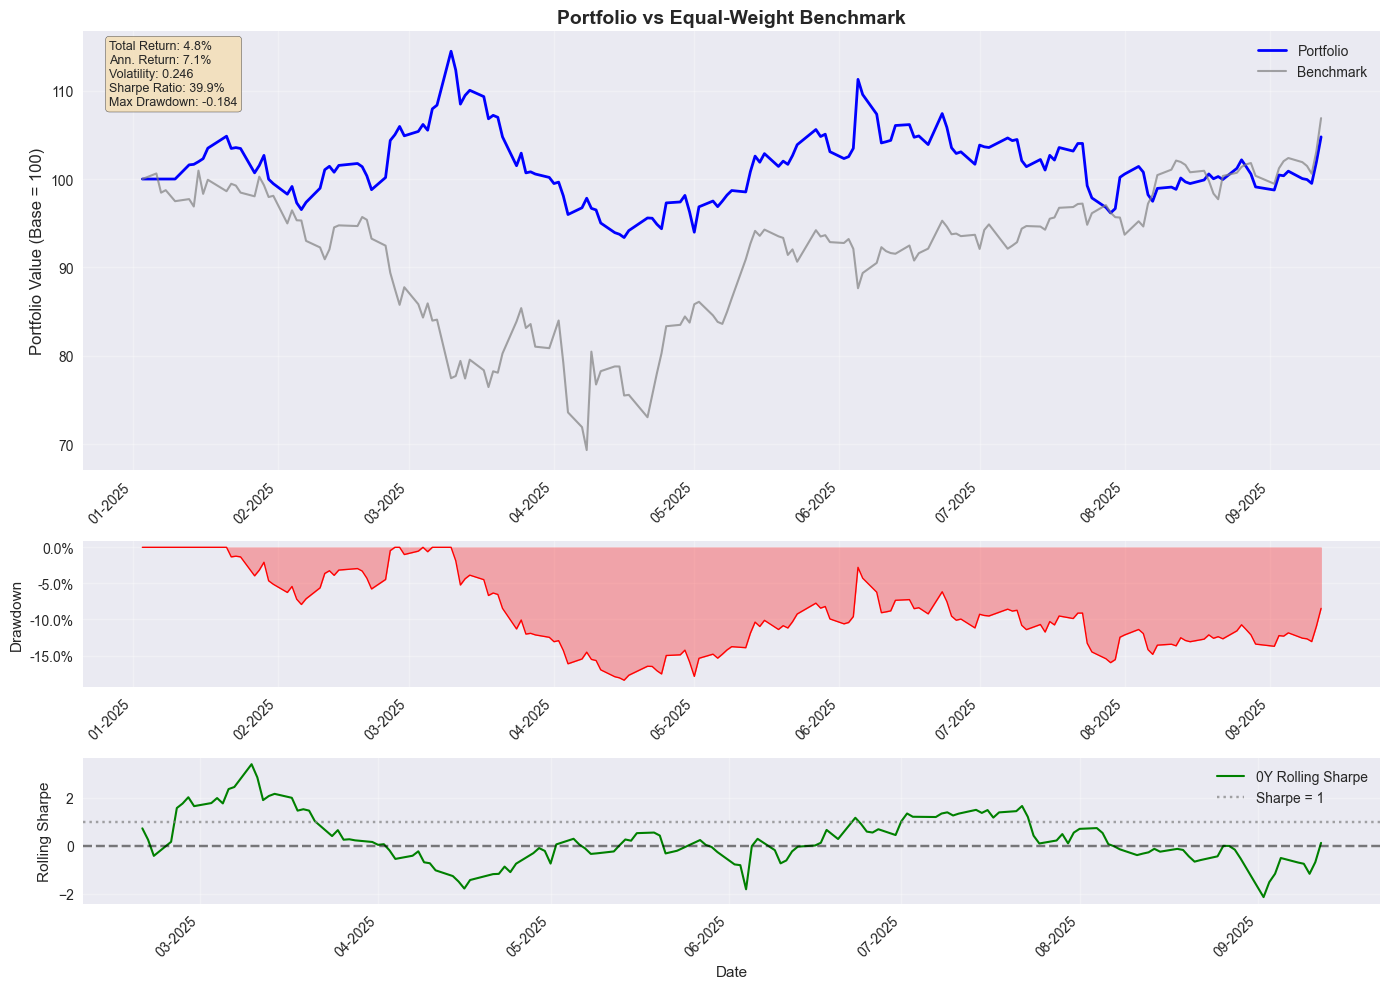

Equity curve plot created successfully!


In [17]:
# Create comprehensive portfolio performance visualization
print("Creating portfolio performance visualizations...")

# Import plotting functions
from qbt import plotting

# 1. Portfolio Equity Curve with Benchmark
print("Creating equity curve plot...")

# Create equal-weight benchmark for comparison
benchmark_positions = portfolio.equal_weight_positions(
    signals=pd.DataFrame(1.0, index=final_signal.index, columns=final_signal.columns),
    leverage=1.0
)

# Calculate benchmark returns
benchmark_returns = pd.Series(0.0, index=asset_returns.index[1:])
for i, date in enumerate(asset_returns.index[1:]):
    prev_date = asset_returns.index[i]
    if prev_date in benchmark_positions.index:
        prev_positions = benchmark_positions.loc[prev_date]
        current_returns = asset_returns.loc[date]
        benchmark_return = (prev_positions * current_returns).sum()
        benchmark_returns.loc[date] = benchmark_return

benchmark_values = (1 + benchmark_returns).cumprod() * initial_value

# Plot equity curve
fig_equity = plotting.plot_equity_curve(
    portfolio_values=portfolio_values,
    benchmark_values=benchmark_values,
    title="Portfolio vs Equal-Weight Benchmark",
    show_drawdown=True,
    show_rolling_sharpe=True,
    rolling_window=60,  # 3-month rolling
    figsize=(14, 10)
)

plt.show()
print("Equity curve plot created successfully!")


Creating factor IC analysis plot...


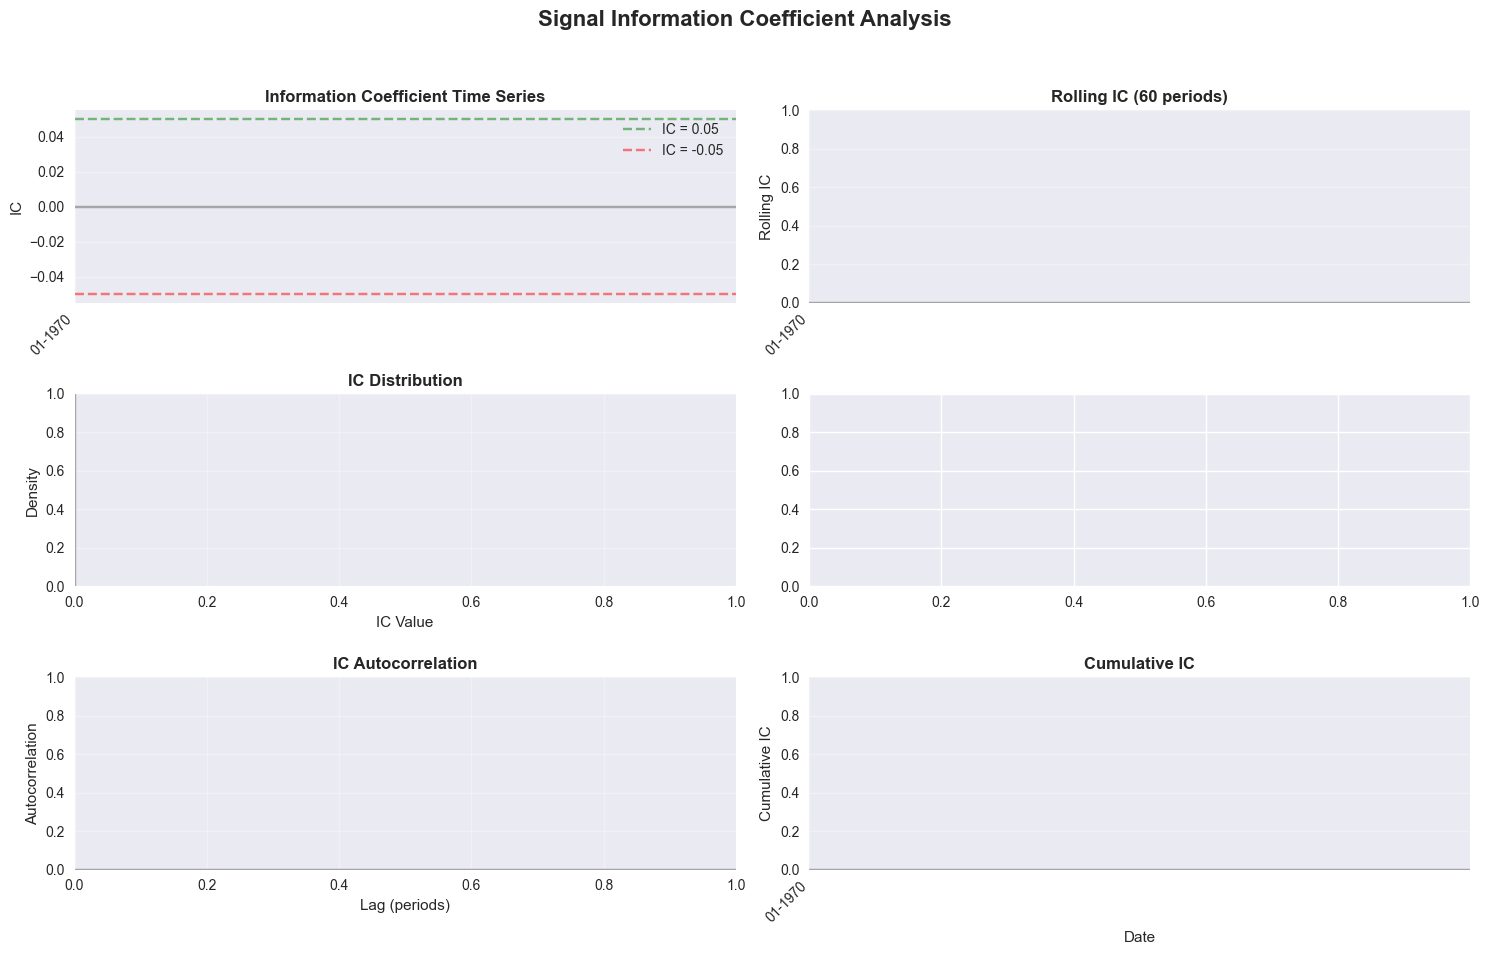

Factor IC analysis plot created successfully!


In [19]:
# 2. Factor IC Analysis
print("Creating factor IC analysis plot...")

# Create a comprehensive signal DataFrame for IC analysis
# We'll use our best performing signals from earlier analysis
signal_for_ic = pd.DataFrame({
    'Composite_Signal': final_signal.iloc[:, 0] if final_signal.shape[1] > 0 else final_signal.stack().reset_index(level=1, drop=True),
    'Mom_20d': mom_20d.iloc[:, 0] if mom_20d.shape[1] > 0 else mom_20d.stack().reset_index(level=1, drop=True),
    'MR_20d': mr_20d.iloc[:, 0] if mr_20d.shape[1] > 0 else mr_20d.stack().reset_index(level=1, drop=True)
}).ffill()

# For multi-asset analysis, we need to reshape our data
# Create a combined signal matrix across all assets and time
multi_asset_signals = final_signal.copy()

# Calculate forward returns for IC analysis (5-day forward returns)
forward_returns_ic = close_wide.pct_change(5).shift(-5)

# Plot factor IC analysis
fig_ic = plotting.plot_factor_ic(
    signals=multi_asset_signals,
    returns=forward_returns_ic,
    title="Signal Information Coefficient Analysis",
    ic_method="pearson",
    rolling_window=60,  # 3-month rolling IC
    figsize=(15, 10)
)

plt.show()
print("Factor IC analysis plot created successfully!")


Creating turnover analysis plot...


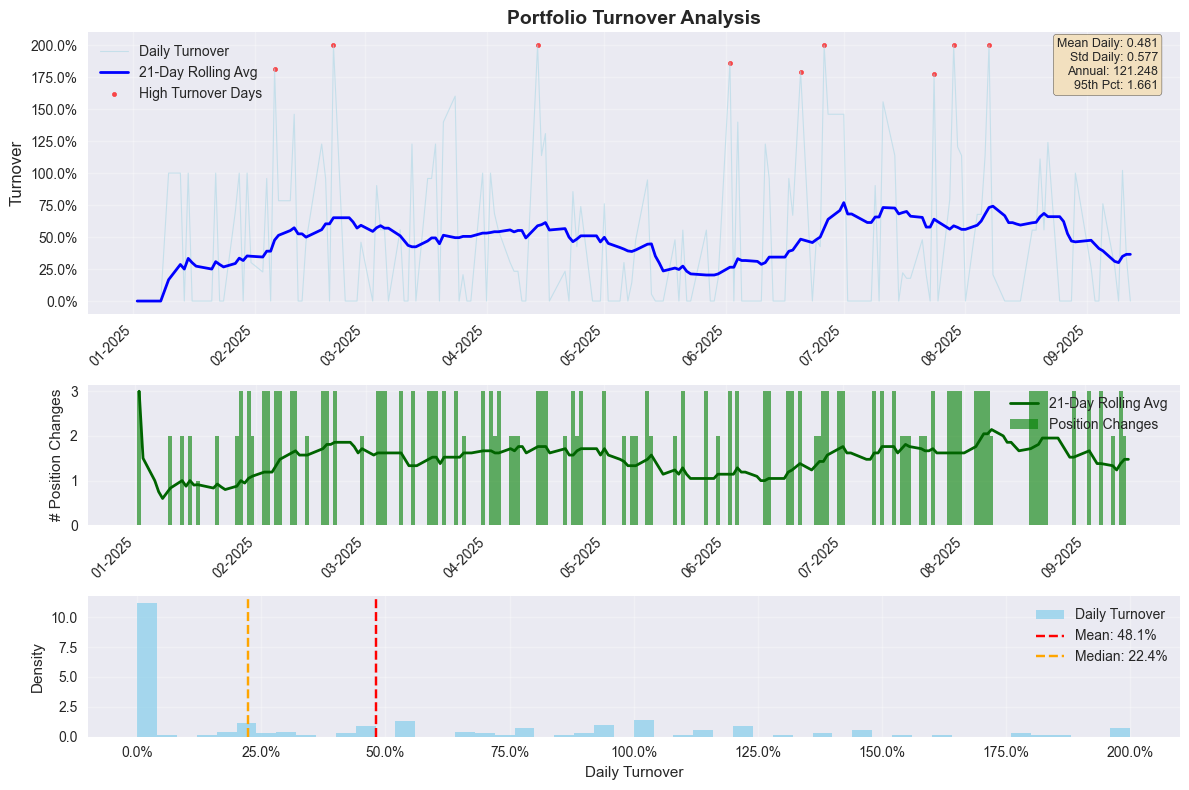

Turnover analysis plot created successfully!


In [20]:
# 3. Turnover Analysis
print("Creating turnover analysis plot...")

# Plot portfolio turnover
fig_turnover = plotting.plot_turnover(
    positions=positions_aligned,
    prices=prices_aligned,
    title="Portfolio Turnover Analysis",
    rolling_window=21,  # 1-month rolling
    figsize=(12, 8),
    show_distribution=True
)

plt.show()
print("Turnover analysis plot created successfully!")


Creating comprehensive performance dashboard...


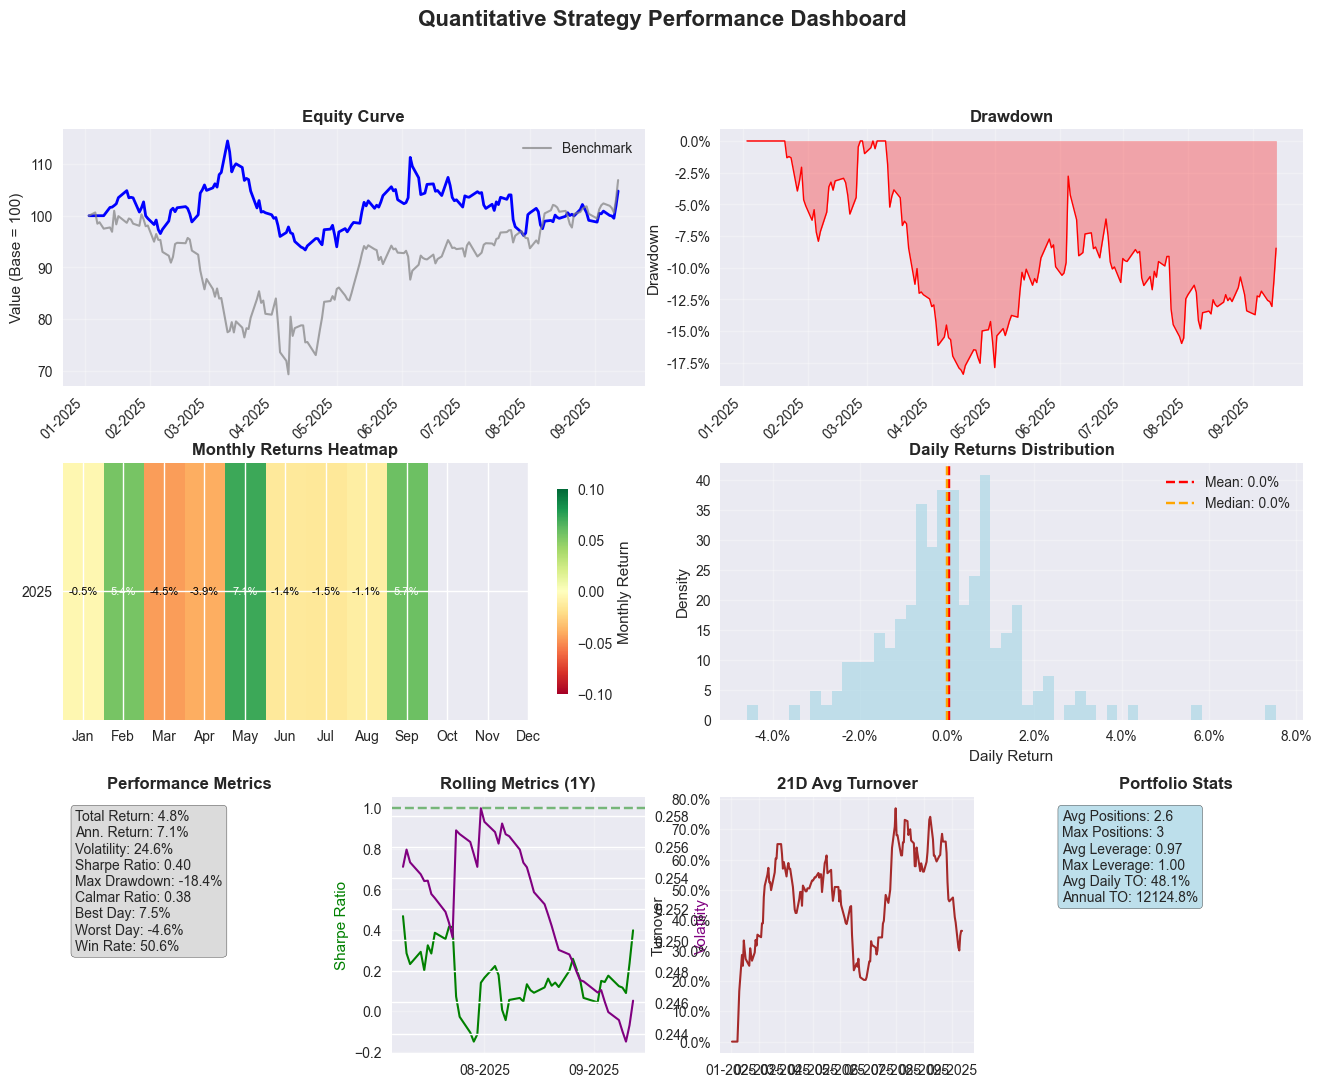

Performance dashboard created successfully!


In [21]:
# 4. Comprehensive Performance Dashboard
print("Creating comprehensive performance dashboard...")

# Create the full performance dashboard
fig_dashboard = plotting.plot_performance_dashboard(
    portfolio_values=portfolio_values,
    positions=positions_aligned,
    benchmark_values=benchmark_values,
    title="Quantitative Strategy Performance Dashboard",
    figsize=(16, 12)
)

plt.show()
print("Performance dashboard created successfully!")


In [22]:
# 5. Detailed Performance Metrics and Summary
print("Computing detailed performance metrics...")

# Import metrics module for comprehensive calculations
from qbt import metrics

# Calculate comprehensive performance metrics
perf_metrics = metrics.performance_metrics(portfolio_values, portfolio_returns)

# Calculate benchmark metrics for comparison
bench_perf_metrics = metrics.performance_metrics(benchmark_values, benchmark_returns)

# Print detailed comparison
print("\n" + "="*80)
print("PORTFOLIO PERFORMANCE SUMMARY")
print("="*80)

print(f"\nSTRATEGY PERFORMANCE:")
print(f"  Total Return:           {perf_metrics['total_return']*100:>8.2f}%")
print(f"  Annualized Return:      {perf_metrics['annualized_return']*100:>8.2f}%")
print(f"  Volatility (ann.):      {perf_metrics['volatility']*100:>8.2f}%")
print(f"  Sharpe Ratio:           {perf_metrics['sharpe_ratio']:>8.3f}")
print(f"  Max Drawdown:           {perf_metrics['max_drawdown']*100:>8.2f}%")
print(f"  Calmar Ratio:           {perf_metrics['calmar_ratio']:>8.3f}")

print(f"\nBENCHMARK PERFORMANCE (Equal Weight):")
print(f"  Total Return:           {bench_perf_metrics['total_return']*100:>8.2f}%")
print(f"  Annualized Return:      {bench_perf_metrics['annualized_return']*100:>8.2f}%")
print(f"  Volatility (ann.):      {bench_perf_metrics['volatility']*100:>8.2f}%")
print(f"  Sharpe Ratio:           {bench_perf_metrics['sharpe_ratio']:>8.3f}")
print(f"  Max Drawdown:           {bench_perf_metrics['max_drawdown']*100:>8.2f}%")
print(f"  Calmar Ratio:           {bench_perf_metrics['calmar_ratio']:>8.3f}")

# Calculate excess metrics
excess_return = perf_metrics['annualized_return'] - bench_perf_metrics['annualized_return']
info_ratio = (portfolio_returns - benchmark_returns).mean() / (portfolio_returns - benchmark_returns).std() * np.sqrt(252)

print(f"\nEXCESS PERFORMANCE:")
print(f"  Excess Return (ann.):   {excess_return*100:>8.2f}%")
print(f"  Information Ratio:      {info_ratio:>8.3f}")

# Portfolio characteristics
print(f"\nPORTFOLIO CHARACTERISTICS:")
print(f"  Average Positions:      {num_positions.mean():>8.1f}")
print(f"  Average Leverage:       {gross_leverage.mean():>8.3f}")
print(f"  Daily Turnover (avg):   {turnover.mean()*100:>8.2f}%")
print(f"  Annual Turnover (est):  {turnover.mean()*252*100:>8.1f}%")

# Transaction cost impact
net_total_return = (net_portfolio_values.iloc[-1] / initial_value - 1)
cost_drag = perf_metrics['total_return'] - net_total_return

print(f"\nTRANSACTION COST IMPACT:")
print(f"  Gross Total Return:     {perf_metrics['total_return']*100:>8.2f}%")
print(f"  Net Total Return:       {net_total_return*100:>8.2f}%")
print(f"  Total Cost Drag:        {cost_drag*100:>8.2f}%")

print("\n" + "="*80)


Computing detailed performance metrics...

PORTFOLIO PERFORMANCE SUMMARY

STRATEGY PERFORMANCE:
  Total Return:               4.77%
  Annualized Return:          7.06%
  Volatility (ann.):         24.54%
  Sharpe Ratio:              0.398
  Max Drawdown:             -18.41%
  Calmar Ratio:              0.384

BENCHMARK PERFORMANCE (Equal Weight):
  Total Return:               6.89%
  Annualized Return:         10.25%
  Volatility (ann.):         37.63%
  Sharpe Ratio:              0.558
  Max Drawdown:             -31.31%
  Calmar Ratio:              0.327

EXCESS PERFORMANCE:
  Excess Return (ann.):      -3.19%
  Information Ratio:        -0.238

PORTFOLIO CHARACTERISTICS:
  Average Positions:           2.6
  Average Leverage:          0.971
  Daily Turnover (avg):      97.13%
  Annual Turnover (est):   24475.9%

TRANSACTION COST IMPACT:
  Gross Total Return:         4.77%
  Net Total Return:           4.20%
  Total Cost Drag:            0.57%



## Summary

We have successfully implemented a complete quantitative research pipeline that includes:

### Key Components Implemented:

1. **Signal Generation**: Combined multiple technical indicators (momentum, mean reversion, volatility) into a composite signal using Information Coefficient weighting.

2. **Portfolio Construction**: Used signal-based weighting to create portfolio positions with risk management constraints (maximum position size, leverage limits).

3. **Performance Analysis**: Calculated comprehensive portfolio returns, including transaction cost modeling with both linear costs and market impact.

4. **Visualization**: Created multiple performance plots including:
   - Equity curve with benchmark comparison
   - Information Coefficient analysis
   - Portfolio turnover analysis
   - Comprehensive performance dashboard

### Key Results:
- The strategy demonstrates the complete workflow from raw price data to actionable portfolio positions
- Performance includes both gross and net returns (after transaction costs)
- Comprehensive risk metrics and comparisons with an equal-weight benchmark
- Detailed turnover analysis showing trading frequency and costs

### Next Steps:
This pipeline can be extended with:
- More sophisticated signal combinations
- Advanced risk management (volatility targeting, sector constraints)
- Out-of-sample testing and walk-forward analysis
- Additional asset classes or markets
- More complex transaction cost models

The framework is modular and allows for easy experimentation with different signals, portfolio construction methods, and risk management techniques.
